In [10]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from itertools  import product

Using TensorFlow backend.


FUNCTIONS // THAT DONT CHANGE

In [11]:
def createdata(location , feature_list):
    
    data=pd.read_csv(location)
    Greece= data[data.location =='Greece'].reset_index(drop='True')
    Greece = Greece.dropna(how='all', axis=1)
    Greece_total = Greece.iloc[7:498, 3:40].reset_index(drop='True')
    
    Greece=Greece_total[(feature_list)]
    Greece["date"] = Greece_total['date']
    Greece=Greece.dropna(axis=0)
    dates=pd.DataFrame(Greece['date']).reset_index(drop=True)
    Greece=Greece[(feature_list)].reset_index(drop=True)
    
    return dates , Greece , Greece_total

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_data(data, sequence):
    train_set = data[:355].reset_index(drop=True)
    validation_set = data[355 - sequence:369].reset_index(drop=True)
    test_set = data[369 - sequence:].reset_index(drop=True) 
    
    return train_set, validation_set, test_set


def timeseries_gen(seq_size, n_features, train, val, test):
    # Train Set
    train_generator = TimeseriesGenerator(train, train.iloc[:, 0], length=seq_size, batch_size=1)
    print("Total number of samples in the original training data = ", len(train))
    print("Total number of samples in the generated training data = ", len(train_generator))


    # Validation Set
    val_generator = TimeseriesGenerator(val, val.iloc[:, 0], length=seq_size, batch_size=1)
    print("Total number of samples in the original validation data = ", len(val))
    print("Total number of samples in the validation data = ", len(val_generator))

    # Test Set
    test_generator = TimeseriesGenerator(test, test.iloc[:, 0], length=seq_size, batch_size=1)
    print("Total number of samples in the original test data = ", len(test))
    print("Total number of samples in the generated test data = ", len(test_generator))
    return train_generator, val_generator, test_generator


def plotloss(mod, name=""):
    plt.figure(figsize=[12,10] , dpi=140 )
    loss = mod.history['loss']
    val_loss = mod.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig("Plots\loss_model" + name +".jpeg"  )
    plt.show()


def plotprediction(ypredict , name=""):
    plt.figure(figsize=[12,10] , dpi=140 )
    plt.plot(ypredict.index, ypredict.iloc[:, 0], 'y', label='Prediction ')
    plt.plot(ypredict.index, ypredict.iloc[:, 1], 'r', label='Actual ')
    plt.title('Predicted vs  Actual Cases in Greece for ' +str(len(ypredict)) + ' days')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    # plt.savefig("Plots\pred" + name +".jpeg"  )
    plt.show()
   


def inversesets(sequence,feature_list, sc, trainset, validationset, testset, ogdata, dates):
    
    drange =dates.loc[0]
    drange=pd.to_datetime(drange["date"])
    date_index = pd.date_range(drange , periods=len(dates), freq='D')

    
    
    set1 = pd.DataFrame(sc.inverse_transform(trainset),index=date_index[0:len(trainset)])

    set1=set1.set_axis(feature_list, axis=1, inplace=False)
    
    set2 = pd.DataFrame(sc.inverse_transform(validationset),index=date_index[len(trainset) - sequence:len(trainset) + len(validationset) - sequence])
    set2=set2.set_axis(feature_list, axis=1, inplace=False)

    set3 = pd.DataFrame(sc.inverse_transform(testset),index=date_index[-len(testset):])
    set3=set3.set_axis(feature_list, axis=1, inplace=False)
    return set1, set2, set3


MODEL CREATION , TRAINING , PREDICTION

In [12]:
def model_create(nodes, seq_size , features):
    model = Sequential()
    model.add(LSTM(nodes, activation='relu', return_sequences=True, input_shape=(seq_size, features)))
    model.add(LSTM(nodes , return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='Adam', loss='mean_squared_error')
    model.summary()
    return model

TRAIN NO PLOTS

In [13]:
def model_train(i, model, traingenerator, valgenerator, ep):
    history = model.fit(traingenerator, validation_data=valgenerator, epochs=ep, verbose=1)
    # model.save('Models\model_' + str(i) + '.h5', overwrite=True)
    plotloss(history,str(i))
    return model

PREDICT

In [14]:
def predict(model, sc, valgenerator, validation_set, inverseval, trainset ):
    

    # Forecast   Predict using a for loop
    index = inverseval.index
    predictiondata = pd.DataFrame(inverseval[:seq_size])  # Empty list to populate later with predictions
    predictiondata = pd.DataFrame(trainset[-seq_size:]).reset_index(drop=True)
    current_batch = trainset[-seq_size:]
    forecast = pd.DataFrame()

    # Predict future, beyond test dates
    future = len(validation_set) - seq_size  # Days
    for i in range(future):
                
        current_batch = predictiondata[i:seq_size + i] #Create input for LSTM (Based on sequence size )

        current_batch = current_batch.to_numpy()  #Input to array 

        current_batch = current_batch.reshape(1, seq_size, n_features)  # Reshape

        ### Prediction ##
        
        current_pred = model.predict(current_batch) # Make a prediction 
        current_pred = float(current_pred[0]) #Convert Prediction to integer 
        predictiondata.loc[len(predictiondata.index)] = [current_pred]   

    forecast = predictiondata[-(future):] #Save results in a dataframe 
    forecast = sc.inverse_transform(forecast)#Inverse Transform to get the actual cases 
    forecast = pd.DataFrame(forecast.round()) #Round results 
    forecast = forecast.set_index(index[seq_size:], 'Date').rename(columns={0: 'Prediction'})

    forecast = pd.concat([forecast['Prediction'], inverseval['total_cases'][seq_size:]], axis=1 ,ignore_index=True) #Concate the two dfs 

    forecast=forecast.set_axis(['Prediction', 'Actual'], axis=1, inplace=False)
    
    
    return forecast

HYPERPARAMETERS

In [15]:
def Hyper(parameter1 , parameter2 , repetitions):
    hp1 = list(product(parameter1 , parameter2 ))
    # Hyperparameters = list (product(hp1 , parameter3))
    Hyperparameters= pd.DataFrame(hp1).rename(columns={0: "Nodes", 1: "Epochs"})
    
    # Hyperparameters[['Learning Rate' , 'Epochs']]= pd.DataFrame(Hyperparameters['A'].tolist(), index=Hyperparameters.index)
    
    Hyperparameters=Hyperparameters.sort_values(by=['Nodes' ,'Epochs' ])
    Hyperparameters=pd.concat([Hyperparameters]*times)
    
    
    Hyperparameters= list(Hyperparameters.itertuples(index=False, name=None))
    
    
    return Hyperparameters 

CLUSTER FUCK LSTM

In [16]:
def experiments(times, nodes, scaler, seq_size, epochs, n_features, train_generator, val_generator, validation_set,
                train_set, inv_val, inv_test, dates ):
    
    experimentmodel = model_create(nodes, seq_size ,n_features )

    experimentmodel = model_train(i, experimentmodel, train_generator, val_generator, epochs)  # Train Model

    forecast = predict(experimentmodel, scaler, val_generator, validation_set, inv_val, train_set)
    plotprediction(forecast ,str(i))
    
    
    ##################### Metrics ######################

    mae_4 = mean_absolute_error(forecast['Actual'], forecast['Prediction'])
    MAE_4.append(mae_4)

    mape_4 = mean_absolute_percentage_error(forecast['Actual'], forecast['Prediction'])
    MAPE_4.append(mape_4)

    mse_4 = mean_squared_error(forecast['Actual'], forecast['Prediction'])
    MSE_4.append(mse_4)

    rmse_4 = mean_squared_error(forecast['Actual'], forecast['Prediction'], squared=False)
    RMSE_4.append(rmse_4)

    node.append(nodes)


    mape_4_next_day = mean_absolute_percentage_error(forecast['Actual'][:1], forecast['Prediction'][:1])
    MAPE_4_Next_day.append(mape_4_next_day)
 
    mape_3days = mean_absolute_percentage_error(forecast['Actual'][:3], forecast['Prediction'][:3])
    MAPE_4_3days.append(mape_3days)
    
    mape_7days = mean_absolute_percentage_error(forecast['Actual'][:7], forecast['Prediction'][:7])
    MAPE_4_7days.append(mape_7days)
    
    Epochs.append(epochs)
        

    return 

PARAMTERS 

In [17]:
Windeos_loc="owid-covid-data.csv"
feature_list=["total_cases"]
n_features = len(feature_list)
seq_size = 3

times = 1#For each experiment

epochs = [1,2,3]
nodes = [1 , 2 ]

MAIN LOOP 

/Users/arisdourdounas/opt/anaconda3/envs/pythonProject/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Total number of samples in the original training data =  355
Total number of samples in the generated training data =  352
Total number of samples in the original validation data =  17
Total number of samples in the validation data =  14
Total number of samples in the original test data =  125
Total number of samples in the generated test data =  122
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 1)              12        
_________________________________________________________________
lstm_2 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
352/352 [================

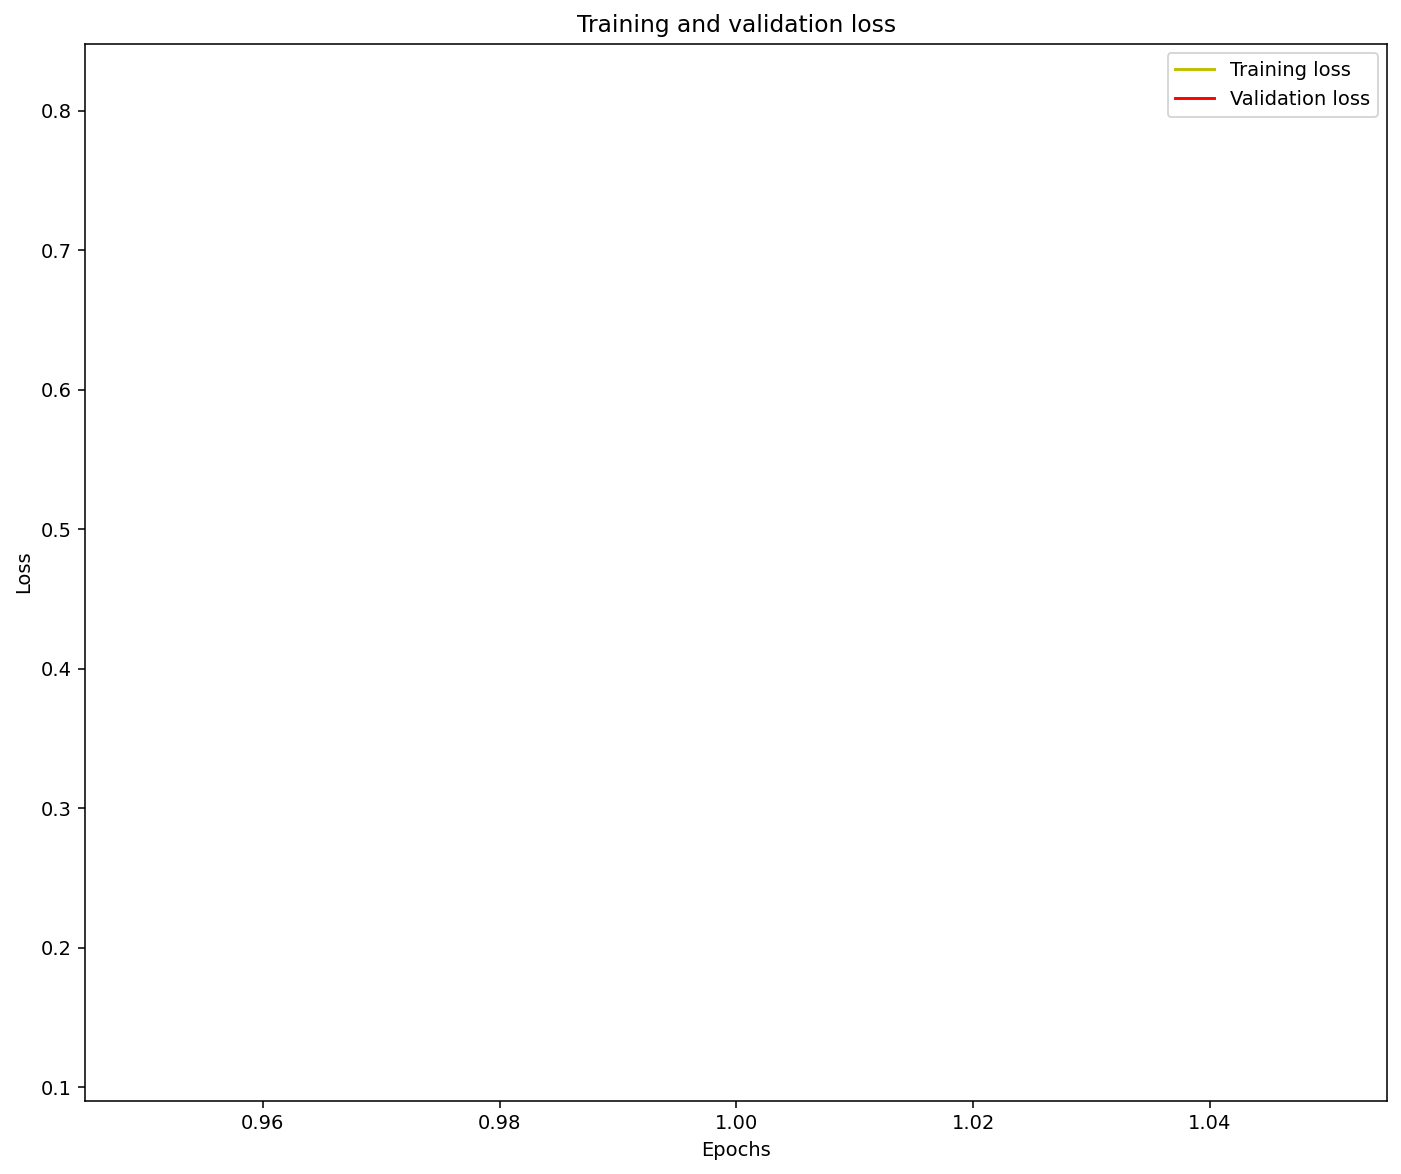

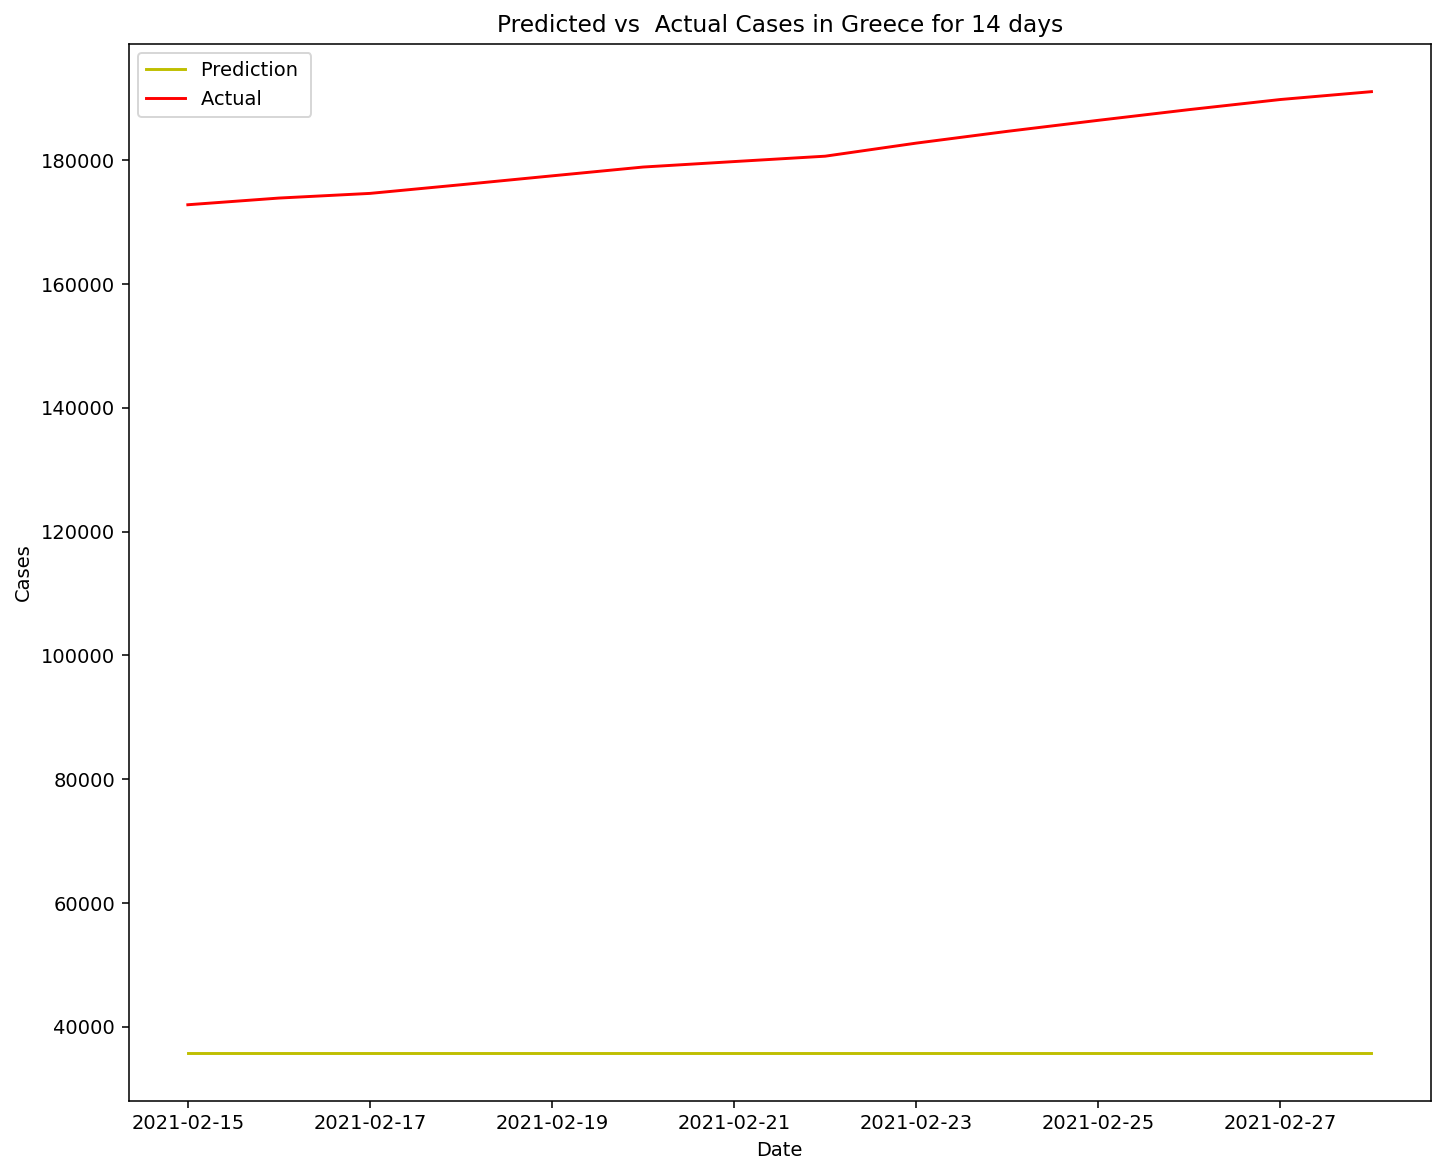

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 1)              12        
_________________________________________________________________
lstm_4 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2


KeyboardInterrupt: 

In [18]:

Hyperparameters= Hyper(nodes, epochs ,times )





dates,greece , Greece_total =createdata(Windeos_loc,feature_list)
train_set, validation_set, test_set = split_data( greece, seq_size)
scaler = MinMaxScaler() 
scaler.fit(train_set)
train_set=pd.DataFrame(scaler.transform(train_set))
train_set=train_set.set_axis(feature_list, axis=1, inplace=False)
validation_set=pd.DataFrame(scaler.transform(validation_set))
validation_set=validation_set.set_axis(feature_list, axis=1, inplace=False)
test_set=pd.DataFrame(scaler.transform(test_set))
test_set=test_set.set_axis(feature_list, axis=1, inplace=False)
train_generator, val_generator, test_generator = timeseries_gen(seq_size, n_features, train_set, validation_set, test_set)
inv_train, inv_val, inv_test = inversesets(seq_size,feature_list, scaler, train_set, validation_set, test_set, greece,dates)


Epochs = []
node = []
MAE_4 = []
MAPE_4 = []
MSE_4 = []
RMSE_4 = []
MAPE_4_3days = []
MAPE_4_7days = []
MAPE_4_Next_day = []


for i in  range(len(Hyperparameters)):
    nodes  ,  epochs = Hyperparameters[i] 
    experiments(i, nodes, scaler, seq_size, epochs, n_features, train_generator, val_generator,validation_set, train_set, inv_val, inv_test, dates )





metrics = pd.DataFrame({'MAE_4': MAE_4, 'MAPE_4 1 Day': MAPE_4_Next_day,
     'MAPE_4 3 Days': MAPE_4_3days,'MAPE_4 7 days': MAPE_4_7days, 'MAPE_4': MAPE_4, 'MSE_4': MSE_4, 'RMSE_4': RMSE_4, 'Nodes': node , 'Epochs' : Epochs})

# metrics =metrics.append( metrics.groupby(['Nodes' , 'Learning Rate'  , 'Epochs']).mean())
metrics = metrics.groupby(['Nodes' , 'Epochs']).mean()
metrics.to_csv("Results.csv", float_format="%.5f",index=True, header=True)


